# NFL Injury Analysis

Injuries are a major concern in all sports and can significantly impact the outcome of a team's success in a given season. Particularly in the NFL, currently some studies indicate that athletes playing on artificial turf are more likely to experience an injury compared to natural grass. The goal of this analysis is to uncover insights on the key factors that contribute to injuries as well understand the effects of synthetic turf versus natural turf can have on player movements.

## 1. Importing libraries

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from itertools import cycle
import numpy as np
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

# import machine learning
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler, SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score

import warnings

warnings.filterwarnings("ignore")

## 2. Loading data

In [7]:
plays = pd.read_csv(r'/Users/satmeerbains/Documents/Python/NFL/NFL/data/PlayList.csv')
players = pd.read_csv(r'/Users/satmeerbains/Documents/Python/NFL/NFL/data/PlayerTrackData.csv')
injuries = pd.read_csv(r'/Users/satmeerbains/Documents/Python/NFL/NFL/data/InjuryRecord.csv')

## 3. Exploratory Data Analysis (EDA)

In [8]:
players.head()

,PlayKey,time,event,x,y,dir,dis,o,s
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09


In [9]:
injuries.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1


### 3.1 Determining the unique plays, players, and games in the plays dataset

In [10]:
unique_players = plays.PlayerKey.nunique()
unique_games = plays.GameID.nunique()
unique_plays = plays.PlayKey.nunique()

print('There are {} players in the dataframe.'.format(unique_players))
print('There are {} games in the dataframe.'.format(unique_games))
print('There are {} plays in the dataframe.'.format(unique_plays))

There are 250 players in the dataframe.
There are 5712 games in the dataframe.
There are 267005 plays in the dataframe.


#### Subsetting and Dropping Duplicates from the plays dataframe to filter for game-level information

In [11]:
# create a dataframe with game-level information
games = plays[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])

#### Remapping Features

##### StadiumType

In [12]:
games2 = games[games['StadiumType'] != 'Cloudy']
mapping = {
    "Oudoor": "Outdoor",
    "Outdoors": "Outdoor",
    "Ourdoor": "Outdoor",
    "Outddors": "Outdoor",
    "Outdor": "Outdoor",
    "Outside": "Outdoor",
    "Indoors": "Indoor",
    "Indoor, Roof Closed": "Indoor",
    "Indoor, Open Roof": "Indoor",
    "Closed Dome": "Dome",
    "Domed, closed": "Dome",
    "Domed, Open": "Dome",
    "Domed, open": "Dome",
    "Dome, closed": "Dome",
    "Domed": "Dome",
    "Retr. Roof-Closed": "Retractable Roof",
    "Outdoor Retr Roof-Open": "Retractable Roof",
    "Retr. Roof - Closed": "Retractable Roof",
    "Retr. Roof-Open": "Retractable Roof",
    "Retr. Roof - Open": "Retractable Roof",
    "Retr. Roof Closed": "Retractable Roof",
    "Open": "Outdoor",
}

games2["StadiumType"] = games2["StadiumType"].astype("string").str.strip().replace(mapping)

##### Temperature & Weather

In [13]:
games2 = games2[games2["Temperature"].between(-20, 120)]

In [14]:
def clean_weather(row):
    cloudy = ['Cloudy 50% change of rain', 'Hazy', 'Cloudy.', 'Overcast', 'Mostly Cloudy',
          'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy',
          'Mostly cloudy', 'Rain Chance 40%',' Partly cloudy', 'Party Cloudy',
          'Rain likely, temps in low 40s', 'Partly Clouidy', 'Cloudy, 50% change of rain','Mostly Coudy', '10% Chance of Rain',
          'Cloudy, chance of rain', '30% Chance of Rain', 'Cloudy, light snow accumulating 1-3"',
          'cloudy', 'Coudy', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy fog started developing in 2nd quarter', 'Cloudy light snow accumulating 1-3"',
         'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy 50% change of rain', 'Cloudy and cold',
       'Cloudy and Cool', 'Partly cloudy']

    clear = ['Clear, Windy',' Clear to Cloudy', 'Clear, highs to upper 80s',
             'Clear and clear','Partly sunny',
             'Clear, Windy', 'Clear skies', 'Sunny', 'Partly Sunny', 'Mostly Sunny', 'Clear Skies',
             'Sunny Skies', 'Partly clear', 'Fair', 'Sunny, highs to upper 80s', 'Sun & clouds', 'Mostly sunny','Sunny, Windy',
             'Mostly Sunny Skies', 'Clear and Sunny', 'Clear and sunny','Clear to Partly Cloudy', 'Clear Skies',
            'Clear and cold', 'Clear and warm', 'Clear and Cool', 'Sunny and cold', 'Sunny and warm', 'Sunny and clear']

    rainy = ['Rainy', 'Scattered Showers', 'Showers', 'Cloudy Rain', 'Light Rain', 'Rain shower', 'Rain likely, temps in low 40s.', 'Cloudy, Rain']

    snow = ['Heavy lake effect snow']

    indoor = ['Controlled Climate', 'Indoors', 'N/A Indoor', 'N/A (Indoors)']

    if row.Weather in cloudy:
        return 'Cloudy'

    if row.Weather in indoor:
        return 'Indoor'

    if row.Weather in clear:
        return 'Clear'

    if row.Weather in rainy:
        return 'Rain'

    if row.Weather in snow:
        return 'Snow'

    if row.Weather in ['Cloudy.', 'Heat Index 95', 'Cold']:
        return np.nan

    return row.Weather

games2['Weather'] = games2.apply(lambda row: clean_weather(row), axis=1)

## 4. Visualizations

### 4.1 Games by Environment and Conditions

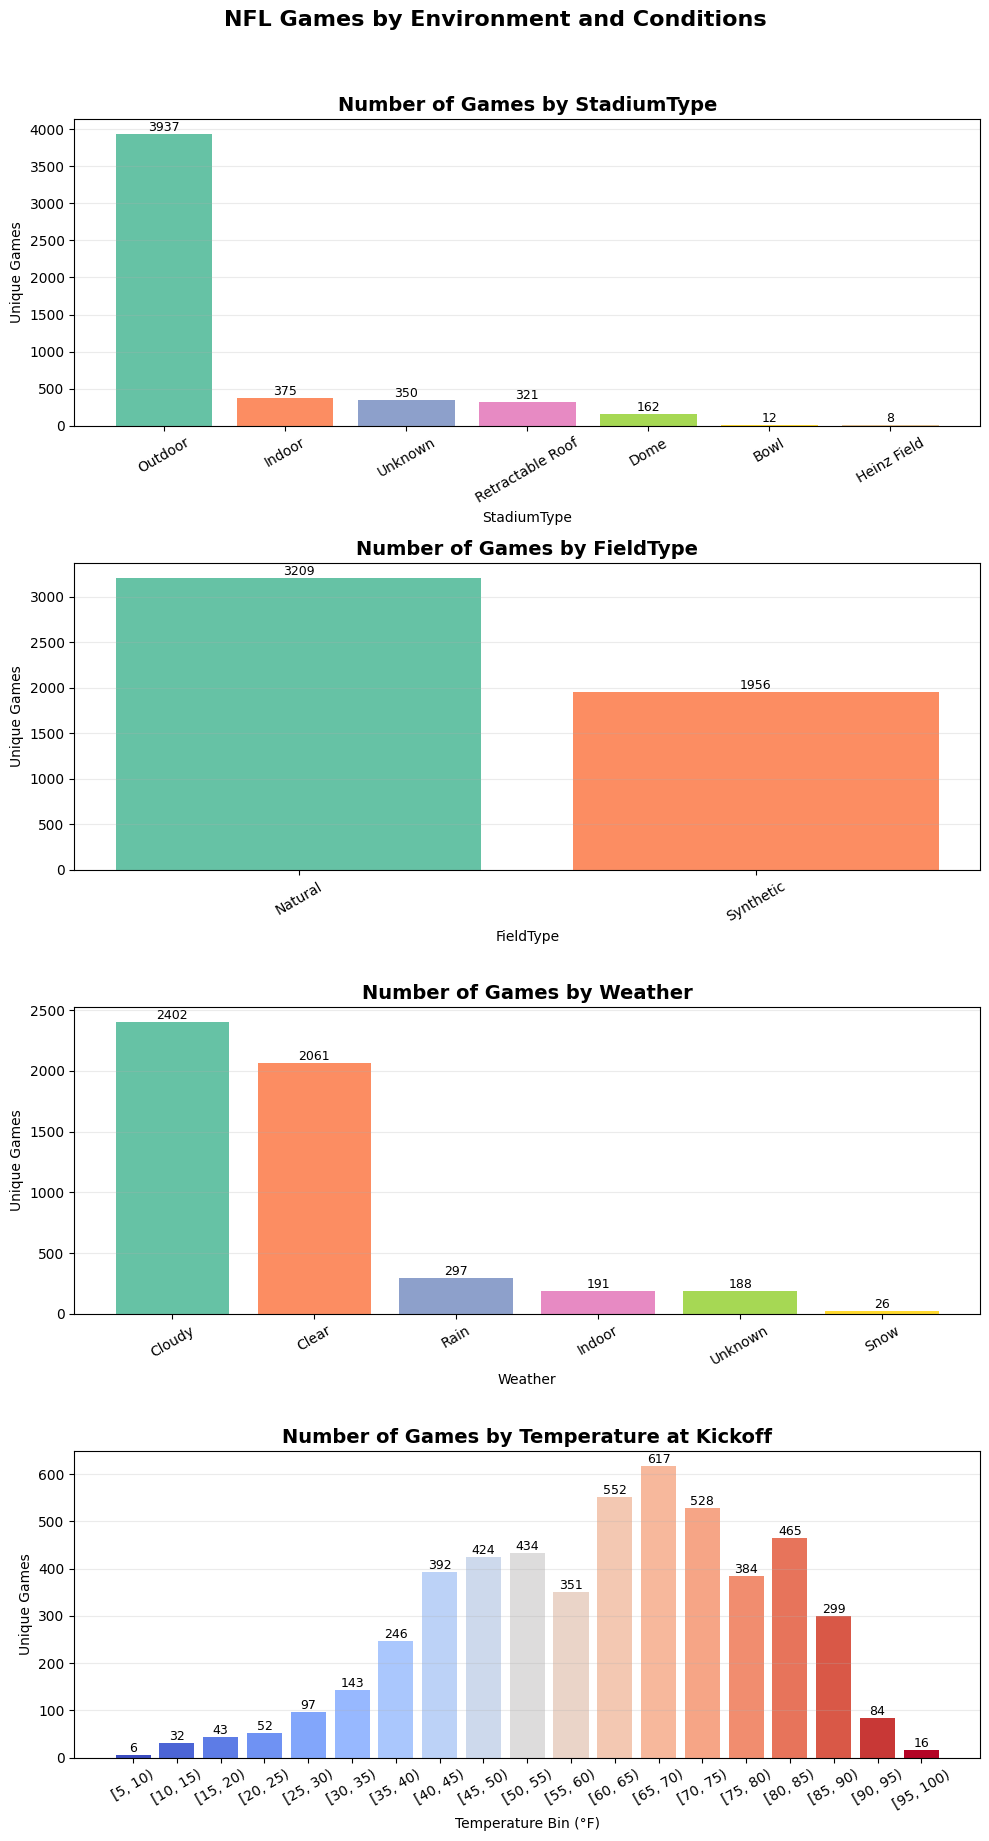

In [15]:
def plot_games_by_features(
    df: pd.DataFrame,
    game_col: str | None = None,
    categorical_cols=("StadiumType", "FieldType", "Weather"),
    temp_col="Temperature",
    temp_bin_width=5,
):
    d = df.copy()

    # --- Auto-detect GameId ---
    if game_col is None:
        candidates = [c for c in d.columns if c.lower() in {"gameid", "game_id", "game"}]
        if not candidates:
            raise ValueError("No GameId column found.")
        game_col = candidates[0]

    # --- Clean categoricals ---
    for c in categorical_cols:
        if c in d.columns:
            d[c] = (
                d[c].astype("string")
                 .str.strip()
                 .fillna("Unknown")
            )

    d[temp_col] = pd.to_numeric(d[temp_col], errors="coerce")

    plots = []

    # --- Categorical plots ---
    for c in categorical_cols:
        if c not in d.columns:
            continue

        counts = (
            d.groupby(c)[game_col]
             .nunique()
             .sort_values(ascending=False)
        )

        plots.append(("categorical", c, counts))

    # --- Temperature bins ---
    if temp_col in d.columns:
        temps = d[[temp_col, game_col]].dropna()
        temps = temps[temps[temp_col].between(-20, 120)]

        if not temps.empty:
            lo = int(temps[temp_col].min() // temp_bin_width * temp_bin_width)
            hi = int(temps[temp_col].max() // temp_bin_width * temp_bin_width + temp_bin_width)

            temps["TempBin"] = pd.cut(
                temps[temp_col],
                bins=range(lo, hi + temp_bin_width, temp_bin_width),
                right=False
            )

            temp_counts = temps.groupby("TempBin")[game_col].nunique()
            plots.append(("temperature", "Kickoff Temperature (°F)", temp_counts))

    # --- Plot ---
    fig, axes = plt.subplots(len(plots), 1, figsize=(10, 4.5 * len(plots)))
    if len(plots) == 1:
        axes = [axes]

    categorical_palette = plt.cm.Set2.colors  # soft, readable

    for ax, (ptype, name, data) in zip(axes, plots):

        if ptype == "categorical":
            colors = categorical_palette[:len(data)]
            bars = ax.bar(data.index.astype(str), data.values, color=colors)

            ax.set_title(
                f"Number of Games by {name}",
                fontsize=14,
                weight="bold"
            )
            ax.set_ylabel("Unique Games")
            ax.set_xlabel(name)

        else:  # temperature
            cmap = cm.coolwarm
            norm = plt.Normalize(data.index.codes.min(), data.index.codes.max())
            colors = cmap(norm(range(len(data))))

            bars = ax.bar(
                data.index.astype(str),
                data.values,
                color=colors
            )

            ax.set_title(
                "Number of Games by Temperature at Kickoff",
                fontsize=14,
                weight="bold"
            )
            ax.set_ylabel("Unique Games")
            ax.set_xlabel("Temperature Bin (°F)")

        # --- Annotate bars ---
        for bar in bars:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{int(bar.get_height())}",
                ha="center",
                va="bottom",
                fontsize=9
            )

        ax.tick_params(axis="x", rotation=30)
        ax.grid(axis="y", alpha=0.25)

    fig.suptitle(
        "NFL Games by Environment and Conditions",
        fontsize=16,
        weight="bold",
        y=1.02
    )

    plt.tight_layout()
    plt.show()
plot_games_by_features(games2)

As we can see from the above visualizations the majority of the games are played outdoors, which indicates that the weather would be an important factor. We also see that althoguh the use of synthetic turf is very common in NFL fields, about 30% more games are played on natural turf.
 We also observe that the temperature and other weather conditions vary significantly

### 4.2 Games Played by Position

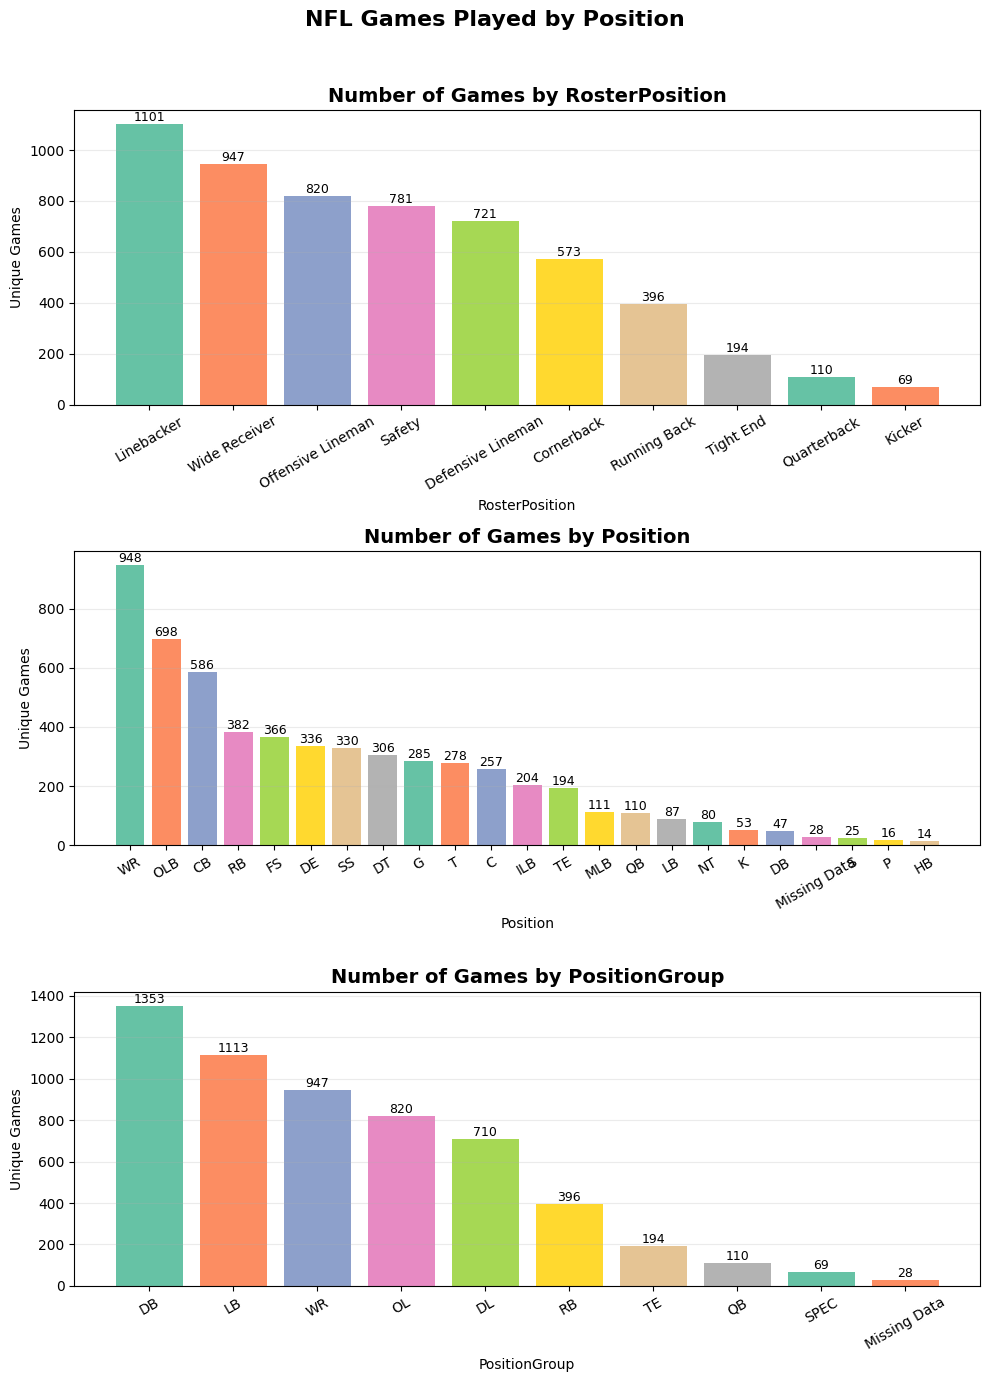

In [16]:
plays2 = plays[['GameID','PlayerKey', 'RosterPosition', 'PlayerGamePlay', 'Position', 'PositionGroup']]

def plot_games_by_position(
    df: pd.DataFrame,
    game_col: str | None = None,
    categorical_cols=("RosterPosition", "Position", "PositionGroup"),
):
    d = df.copy()

    # --- Auto-detect GameId ---
    if game_col is None:
        candidates = [c for c in d.columns if c.lower() in {"gameid", "game_id", "game"}]
        if not candidates:
            raise ValueError("No GameId column found.")
        game_col = candidates[0]

    # --- Clean categoricals ---
    for c in categorical_cols:
        if c in d.columns:
            d[c] = (
                d[c].astype("string")
                 .str.strip()
                 .fillna("Unknown")
            )

    plots = []

    # --- Categorical plots ---
    for c in categorical_cols:
        if c not in d.columns:
            continue

        counts = (
            d.groupby(c)[game_col]
             .nunique()
             .sort_values(ascending=False)
        )

        plots.append(("categorical", c, counts))


    # --- Plot ---
    fig, axes = plt.subplots(len(plots), 1, figsize=(10, 4.5 * len(plots)))
    if len(plots) == 1:
        axes = [axes]

    categorical_palette = plt.cm.Set2.colors  # soft, readable

    for ax, (ptype, name, data) in zip(axes, plots):

        if ptype == "categorical":
            colors = categorical_palette[:len(data)]
            bars = ax.bar(data.index.astype(str), data.values, color=colors)

            ax.set_title(
                f"Number of Games by {name}",
                fontsize=14,
                weight="bold"
            )
            ax.set_ylabel("Unique Games")
            ax.set_xlabel(name)

        else:  # temperature
            cmap = cm.coolwarm
            norm = plt.Normalize(data.index.codes.min(), data.index.codes.max())
            colors = cmap(norm(range(len(data))))

            bars = ax.bar(
                data.index.astype(str),
                data.values,
                color=colors
            )



        # --- Annotate bars ---
        for bar in bars:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{int(bar.get_height())}",
                ha="center",
                va="bottom",
                fontsize=9
            )

        ax.tick_params(axis="x", rotation=30)
        ax.grid(axis="y", alpha=0.25)

    fig.suptitle(
        "NFL Games Played by Position",
        fontsize=16,
        weight="bold",
        y=1.02
    )

    plt.tight_layout()
    plt.show()
plot_games_by_position(plays2)

The above plots show that there some player positions play a significant more amount of games compared to other positions. The more games played can lead to an increased likelihood of a player experiencing an injury.

### 4.3 Games by Play Type

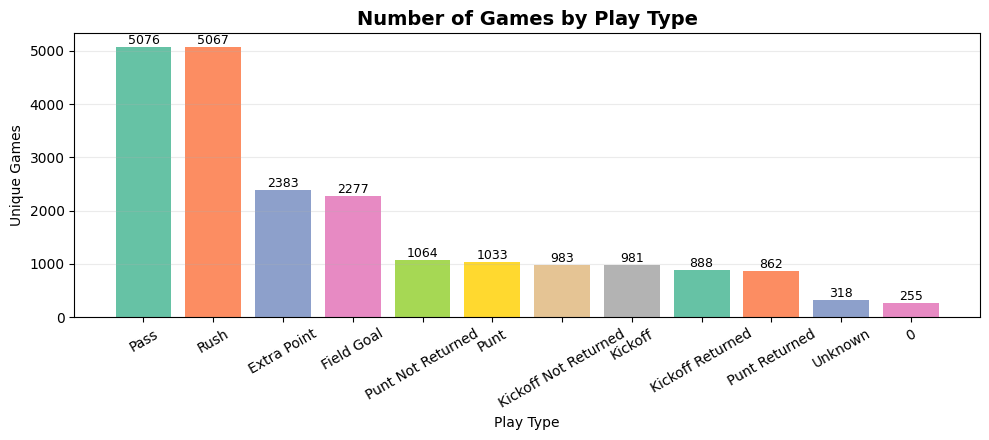

In [17]:
def plot_games_by_playtype(
    df,
    playtype_col="PlayType",
    game_col="GameId",
    top_n=None
):
    d = df.copy()

    # Defensive cleanup
    d[playtype_col] = (
        d[playtype_col]
        .astype("string")
        .str.strip()
        .fillna("Unknown")
    )

    counts = (
        d.groupby(playtype_col)[game_col]
         .nunique()
         .sort_values(ascending=False)
    )

    if top_n:
        counts = counts.head(top_n)

    # Same palette as earlier
    colors = plt.cm.Set2.colors[:len(counts)]

    fig, ax = plt.subplots(figsize=(10, 4.5))

    bars = ax.bar(counts.index.astype(str), counts.values, color=colors)

    ax.set_title(
        "Number of Games by Play Type",
        fontsize=14,
        weight="bold"
    )
    ax.set_xlabel("Play Type")
    ax.set_ylabel("Unique Games")
    ax.tick_params(axis="x", rotation=30)
    ax.grid(axis="y", alpha=0.25)

    # Annotate
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{int(bar.get_height())}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()

plot_games_by_playtype(plays, playtype_col="PlayType", game_col="GameID")

As expected, the majority of plays are passing and rush plays, which are the most physically immersive due to the nature of the contact involved.

### 4.4 Heatmap of the field

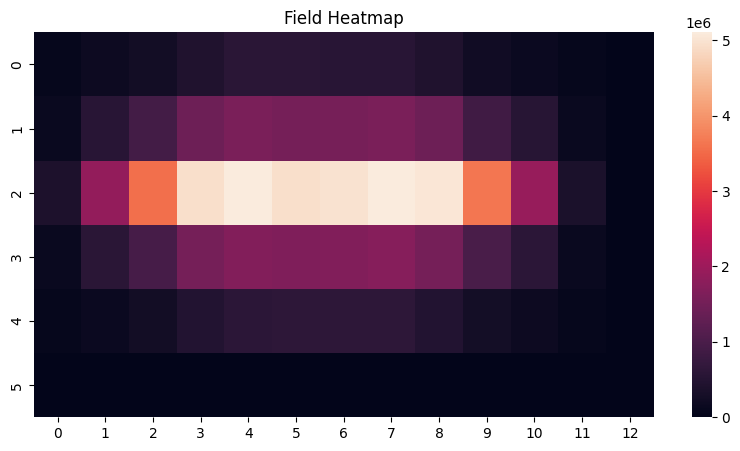

In [18]:
def heatmap(players, xbins=13, ybins=6, annotate = False):
    # create a grid
    x = np.linspace(0, 120, xbins)
    y = np.linspace(0, 53, ybins)

    # initialize heatmap
    hmap = np.zeros((xbins,ybins))

    for i in range(xbins-1):
        for j in range(ybins-1):
            hmap[i,j] = len(players[(players.x >= x[i]) & (players.x <= x[i+1]) & (players.y >= y[j]) & (players.y <= y[j+1])])

    fig = plt.figure(figsize=(10,5))
    ax = sns.heatmap(np.transpose(hmap), annot=annotate, fmt = '.0f')
    plt.title('Field Heatmap')
    plt.show()
heatmap(players)

The above heatmap, the highlighted areas are the portions of the field that have more player activity. We can see, the center of the field is the area that players are more active, which is expected.

### 4.5 Player Injuries

In [19]:
print('There are {} recorded injuries in total.'.format(len(injuries)))

There are 105 recorded injuries in total.


In [20]:
print('There are {} unique players recorded as injured'.format(len(injuries.PlayerKey.unique())))

There are 100 unique players recorded as injured


Since our total amount of recorded injuries is higher count than the number of unique players injured, we know that there are players that were injured more than once in a given season.

In [21]:
print('There are {} PlayKey values missing.'.format(len(injuries) - injuries.PlayKey.count()))

There are 28 PlayKey values missing.


For around 30% of the recorded injuries, we don't know the play in which it took place.

#### 4.5.1 Player Injuries per Category

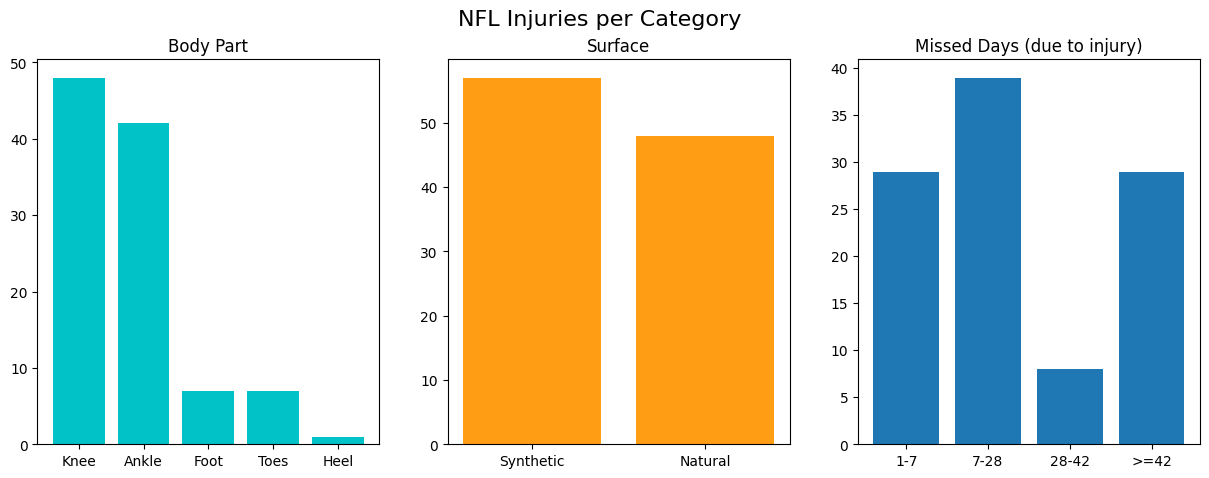

In [22]:
def injury(injuries):
    injury_df_cleaned = injuries.copy()
    injury_df_cleaned.DM_M1 = injury_df_cleaned.DM_M1 - injury_df_cleaned.DM_M7
    injury_df_cleaned.DM_M7 = injury_df_cleaned.DM_M7 - injury_df_cleaned.DM_M28
    injury_df_cleaned.DM_M28 = injury_df_cleaned.DM_M28 - injury_df_cleaned.DM_M42

    fig, axs = plt.subplots(1,3, figsize=(15,5))

    axs[0].bar(injury_df_cleaned.BodyPart.value_counts().keys().values, injury_df_cleaned.BodyPart.value_counts().values, color='#00c2c7')
    axs[0].set_title('Body Part')
   # add_value_labels(axs[0], spacing=5)

    axs[1].bar(injury_df_cleaned.Surface.value_counts().keys().values, injury_df_cleaned.Surface.value_counts().values, color='#ff9e15')
    axs[1].set_title('Surface')
    #add_value_labels(axs[1], spacing=5)

    M1 = injury_df_cleaned.DM_M1.sum()
    M7 = injury_df_cleaned.DM_M7.sum()
    M28 = injury_df_cleaned.DM_M28.sum()
    M42 = injury_df_cleaned.DM_M42.sum()

    axs[2].bar(['1-7', '7-28', '28-42', '>=42'], [M1, M7, M28, M42])
    axs[2].set_title('Missed Days (due to injury)')
    #add_value_labels(axs[2], spacing=5)

    plt.suptitle('NFL Injuries per Category', fontsize=16)
    plt.show()
injury(injuries)

The visualizations above show that knee and ankle injuries occur most often. The data also shows an almost equal number of observations on synthetic and natural playing surfaces.


#### 4.5.2 Player Injuries on Field Heatmap

In [23]:
# joined cleaned games dataset and injury dataset
play_injury_df = injuries.dropna(subset=['PlayKey']).set_index('PlayKey').join(plays.set_index('PlayKey'), how = 'outer', lsuffix='_left', rsuffix='a_right')

# fill null values for the injury columns with zeros
play_injury_df['DM_M1'] = play_injury_df['DM_M1'].fillna(0).astype(int)
play_injury_df['DM_M7'] = play_injury_df['DM_M7'].fillna(0).astype(int)
play_injury_df['DM_M28'] = play_injury_df['DM_M28'].fillna(0).astype(int)
play_injury_df['DM_M42'] = play_injury_df['DM_M42'].fillna(0).astype(int)

# introduce a column with a flag indicating an injury
play_injury_df.DM_M1 = play_injury_df.DM_M1 - play_injury_df.DM_M7
play_injury_df.DM_M7 = play_injury_df.DM_M7 - play_injury_df.DM_M28
play_injury_df.DM_M28 = play_injury_df.DM_M28 - play_injury_df.DM_M42

play_injury_df['Injury'] = play_injury_df['DM_M1'] + play_injury_df['DM_M7'] + play_injury_df['DM_M28']+ play_injury_df['DM_M42']

# drop duplicated surface column
play_injury_df = play_injury_df.drop(columns=['Surface'])

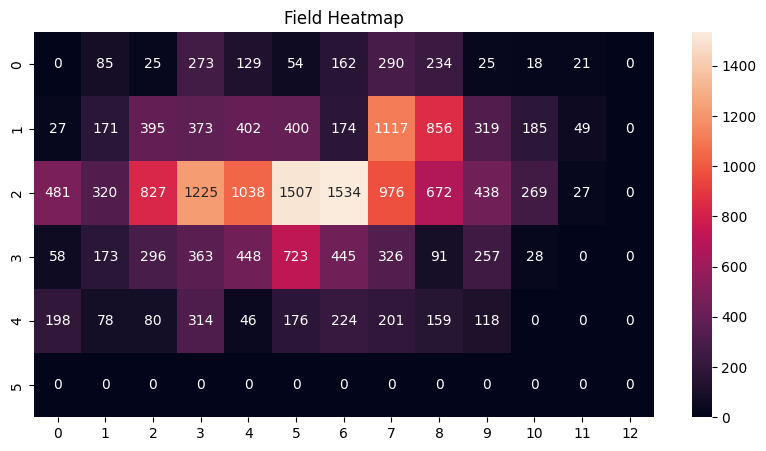

In [24]:
# find the keys of the plays related to injuries
play_injuries = play_injury_df.reset_index().dropna()[['PlayKey']]
# merge the playkeys associated with injuries with players' positions
player_injuries = players.merge(play_injuries, on='PlayKey', how='inner') # use inner join!
# visualize the heatmap
heatmap(player_injuries, annotate = True)


The injury heatmap doesn’t perfectly align with the overall field-traffic heatmap, suggesting that certain areas may be disproportionately high-risk. This spatial pattern can be translated into model features, such as “high-risk zone” indicators or location-based aggregates for injury prediction. We can potentially use this insight in the future for machine learing applications to predict injury


#### 4.5.3 Player Injuries on Field Kernel Density Estimation (KDE) Plot

<Figure size 1000x500 with 0 Axes>

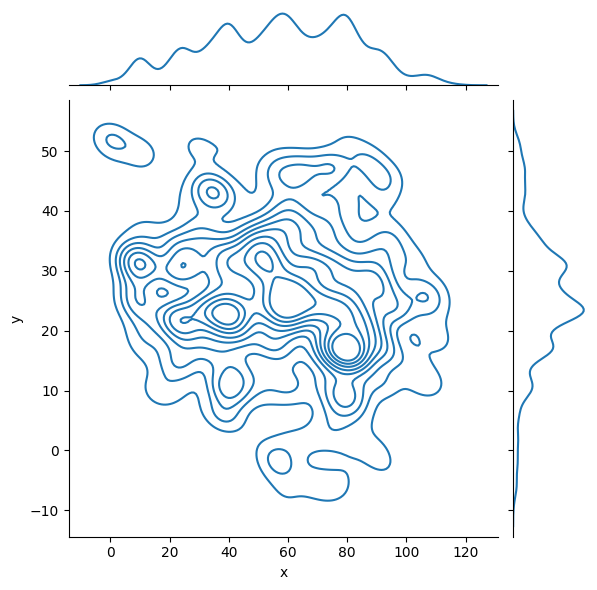

In [25]:
def injuries_kde(player_df):
    # plot kde
    fig = plt.figure(figsize=(10,5))
    ax = sns.jointplot(x="x", y="y", data=player_df, kind="kde")
    plt.show()

injuries_kde(player_injuries)

### 4.6 Injury Analysis and Game Timeline

We select random players that have been injured and plot the timeline of their games throughout the season highlighting the which game days an injury occured.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

def player_games_timeline(player_keys, play_df, injury_df):
    """
    Plot game timelines for one or more players with inline labels
    and a minimal legend (injury marker only).
    """

    # Normalize input
    if not isinstance(player_keys, (list, tuple, set)):
        player_keys = [player_keys]

    fig, ax = plt.subplots(figsize=(20, 5))
    color_cycle = cycle(plt.cm.Set2.colors)

    injury_legend_added = False

    for idx, player_key in enumerate(player_keys):
        color = next(color_cycle)

        # Player games
        player_games = (
            play_df[play_df.PlayerKey == player_key]
            [['GameID', 'PlayerDay']]
            .drop_duplicates(subset=['GameID'])
            .sort_values('PlayerDay')
        )

        if player_games.empty:
            continue

        game_days = player_games.PlayerDay.values
        y = np.full(len(game_days), idx)

        # ---- Games timeline ----
        ax.plot(
            game_days,
            y,
            color=color,
            linewidth=2
        )

        ax.scatter(
            game_days,
            y,
            color=color,
            s=70,
            zorder=3
        )

        # ---- Inline label (at last game) ----
        ax.text(
            game_days[-1] + 0.5,   # small right offset
            idx,
            str(player_key),
            va="center",
            fontsize=11,
            color=color,
            weight="bold"
        )

        # ---- Injury markers ----
        injury_games = injury_df.loc[
            injury_df.PlayerKey == player_key, "GameID"
        ].unique()

        injury_days = player_games.loc[
            player_games.GameID.isin(injury_games), "PlayerDay"
        ].values

        if len(injury_days) > 0:
            ax.scatter(
                injury_days,
                np.full(len(injury_days), idx),
                color="#e01e5a",
                marker="x",
                s=250,
                zorder=4,
                label="Injury" if not injury_legend_added else None
            )
            injury_legend_added = True

    # ---- Formatting ----
    ax.set_title(
        "Player Games Timeline",
        fontsize=14,
        weight="bold"
    )
    ax.set_xlabel("Days Played")
    ax.set_yticks([])  # labels are on the lines now
    ax.grid(axis="x", alpha=0.25)

    if injury_legend_added:
        ax.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

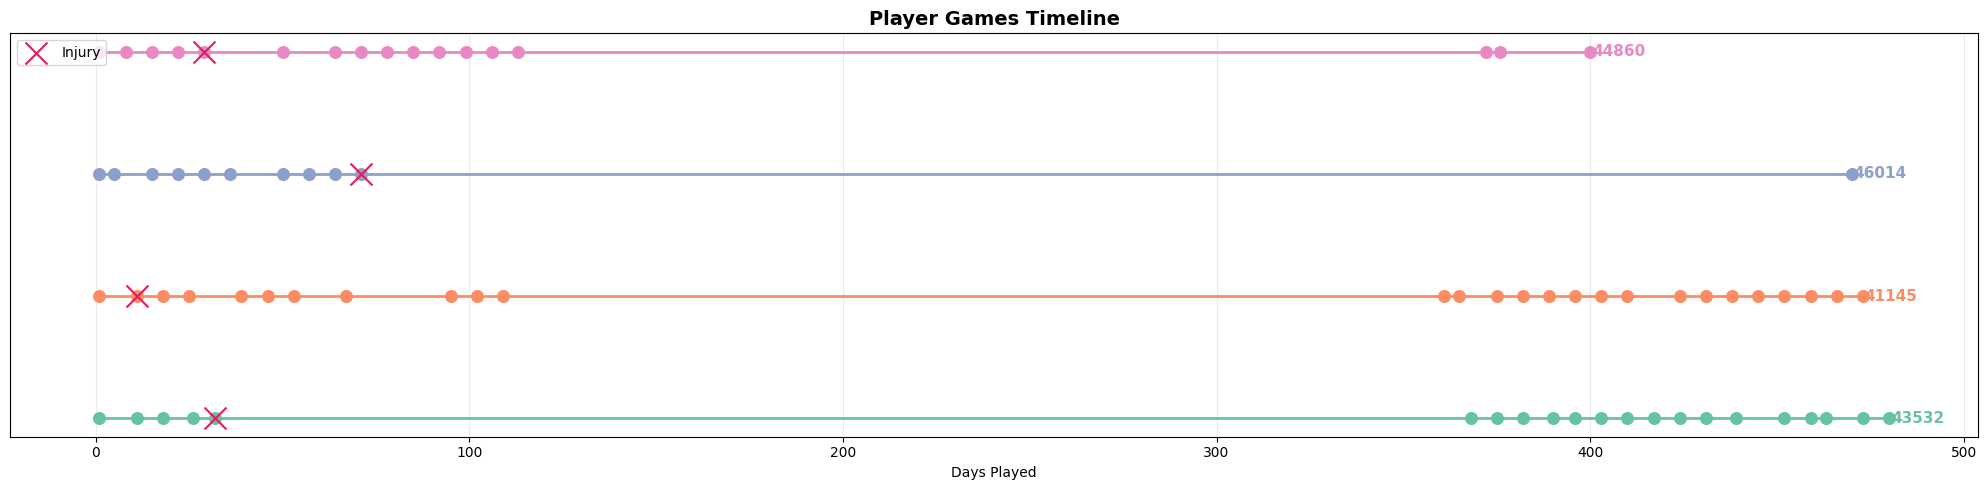

In [27]:
player_games_timeline([43532, 41145, 46014, 44860],plays, injuries)
 #   [26624, 45099, 33337,46394]
#injuries['PlayerKey'].unique()

Across two full seasons, the above plot of the timeline shows that most injuries at the beginning of the season

So is the speed of the player, his position on the field and the number of the game (`PlayerGame`) correlated with the injury?

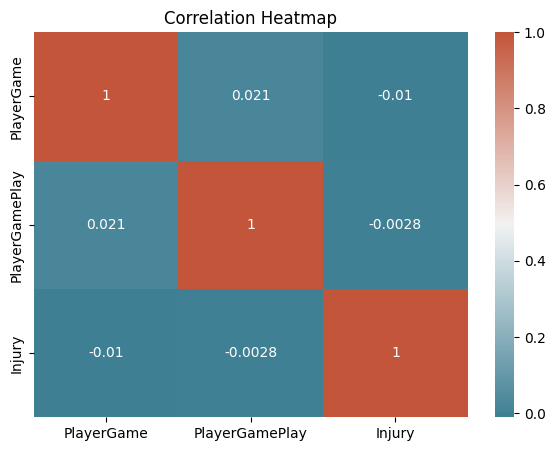

In [28]:

play_injury = play_injury_df[['PlayerGame', 'PlayerGamePlay', 'Injury']]
corrs = play_injury.corr()

fig = plt.figure(figsize=(7,5))
sns.heatmap(corrs, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

The diagram above shows that there is no correlation between the injury and the number of games/plays per game played.

## 5. Statistical Analysis of Player Injuries

### 5.1 Data Preparation

In order to explore the dependencies between factors that occur in an NFL game that lead to player injury, we will merge the injuries dataset to the games dataset

In [29]:
# joined cleaned games dataset and injury dataset
game_injury_df = injuries.set_index('GameID').join(games2.set_index('GameID'), how = 'outer')

# fill null values for the injury columns with zeros
game_injury_df['DM_M1'] = game_injury_df['DM_M1'].fillna(0).astype(int)
game_injury_df['DM_M7'] = game_injury_df['DM_M7'].fillna(0).astype(int)
game_injury_df['DM_M28'] = game_injury_df['DM_M28'].fillna(0).astype(int)
game_injury_df['DM_M42'] = game_injury_df['DM_M42'].fillna(0).astype(int)

game_injury_df.DM_M1 = game_injury_df.DM_M1 - game_injury_df.DM_M7
game_injury_df.DM_M7 = game_injury_df.DM_M7 - game_injury_df.DM_M28
game_injury_df.DM_M28 = game_injury_df.DM_M28 - game_injury_df.DM_M42

# introduce a column with a flag indicating an injury
game_injury_df['Injury'] = game_injury_df['DM_M1'] + game_injury_df['DM_M7'] + game_injury_df['DM_M28'] + game_injury_df['DM_M42']

# drop duplicated surface column
game_injury_df = game_injury_df.drop(columns=['Surface'])

# drop play-level features just for now
game_injury_df = game_injury_df.drop(columns=['PlayerKey', 'PlayKey'])

# create dummy variables
game_injury_df_dummies = pd.get_dummies(game_injury_df, dummy_na = True, drop_first = True).drop(columns=['FieldType_nan'])

### 5.2 Correlations

#### 5.2.1 Injuries & Enviromental Factors

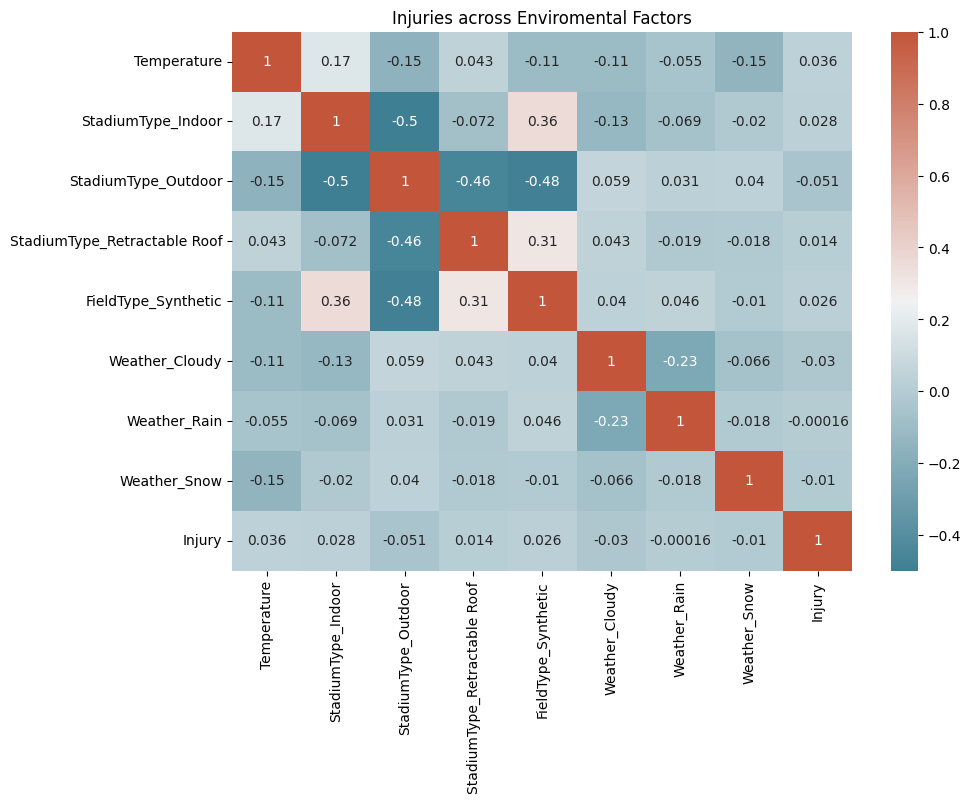

In [30]:
corr_df = game_injury_df_dummies[['Temperature', 'StadiumType_Indoor', 'StadiumType_Outdoor', 'StadiumType_Retractable Roof',
                                 'FieldType_Synthetic', 'Weather_Cloudy', 'Weather_Rain', 'Weather_Snow', 'Injury']].corr()

fig = plt.figure(figsize=(10,7))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Injuries across Enviromental Factors')
plt.show()

As shown in the correlation table above, there is significant relationship between the environmental factors in a game and likelihood of injury.

#### 5.2.2 Injuries & Play Types

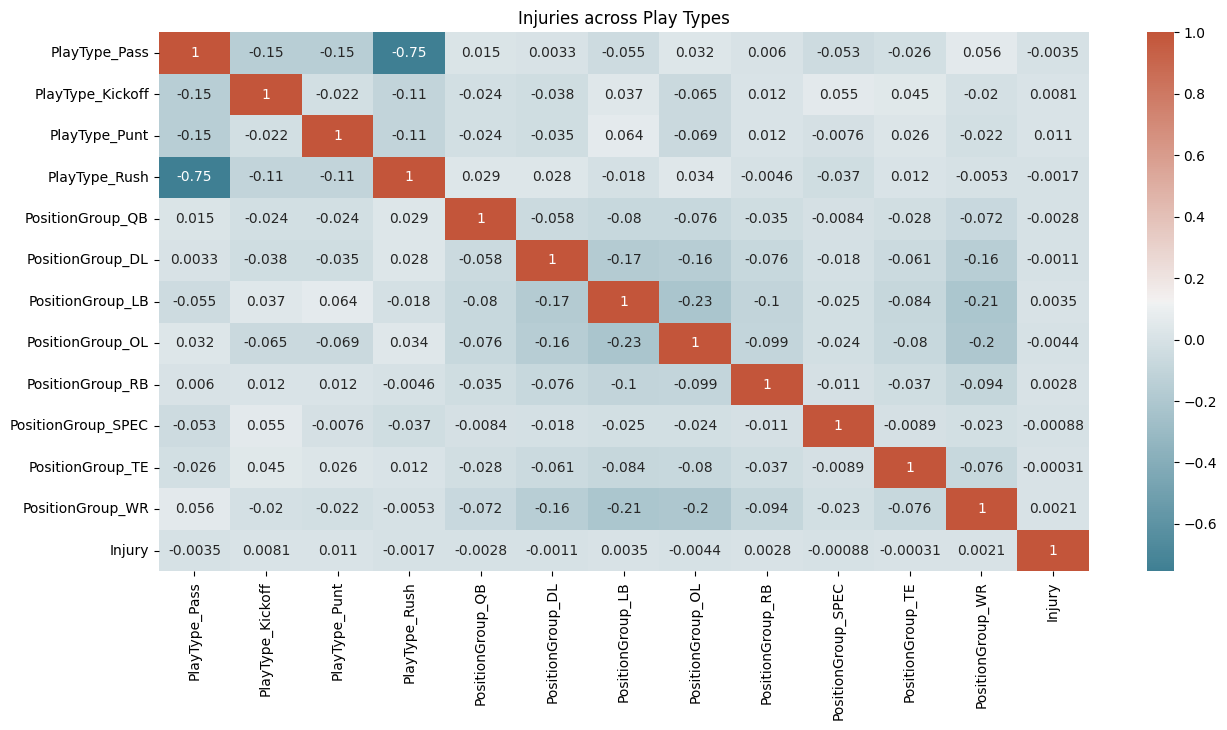

In [31]:
# create dummy variables
play_injury_df_dummies = pd.get_dummies(play_injury_df, columns = ['PlayType', 'PositionGroup'], dummy_na = True, drop_first = True)

corr_df = play_injury_df_dummies[['PlayType_Pass', 'PlayType_Kickoff', 'PlayType_Punt', 'PlayType_Rush',
                                  'PositionGroup_QB', 'PositionGroup_DL', 'PositionGroup_LB', 'PositionGroup_OL',
                                  'PositionGroup_RB', 'PositionGroup_SPEC', 'PositionGroup_TE', 'PositionGroup_WR',
                                  'Injury']].corr()

fig = plt.figure(figsize=(15,7))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Injuries across Play Types')
plt.show()

As shown in the correlation table above, there is no significant relationship between a player's position in game and likelihood of injury.

In [32]:
#### 5.2.3 Injuries & Number of Games Played

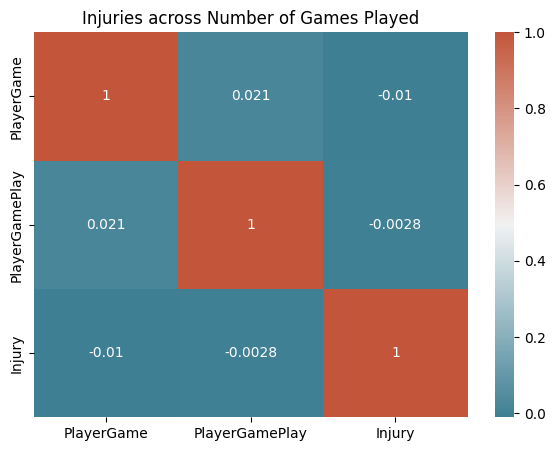

In [33]:
play_injury = play_injury_df[['PlayerGame', 'PlayerGamePlay', 'Injury']]
corrs = play_injury.corr()

fig = plt.figure(figsize=(7,5))
sns.heatmap(corrs, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Injuries across Number of Games Played')
plt.show()

As shown in the correlation table above, there is no significant relationship between the number of games played and likelihood of injury

### 5.3 Hypothesis Testing

We would like to understand if whether injuries on synthetic turf are potentially significantly higher when compared to natural grass.

##### Null hypothesis: The likelihood of a player experiencing an injury on natural grass is less than or equal to the probability of the injury on synthetic turf.
##### Alternative hypothesis: The likelihood of a player experiencing an injury on natural grass is greater than the probability of the injury on synthetic turf.

In [34]:
# compute the injury probability for synthetic and natural turf
p_injury = game_injury_df[['FieldType', 'Injury']].groupby('FieldType').mean()['Injury']
p_injury

FieldType
Natural      0.014958
Synthetic    0.025038
Name: Injury, dtype: float64

The probability of an injury is higher when playing on synthetic turf


In [35]:
# get number of trials and overall injury rate under null
n_natural = (game_injury_df[['FieldType', 'Injury']].groupby('FieldType').size().iloc[0]).astype(int)
n_synthetic = game_injury_df[['FieldType', 'Injury']].groupby('FieldType').size().iloc[1]
p_null = game_injury_df[['Injury']].mean().iloc[0]

In [36]:
# compute standard error
se_p = np.sqrt(p_null * (1-p_null) * (1/n_natural + 1/n_synthetic))

#  compute z-score and p-value
z = (p_injury.iloc[1] - p_injury.iloc[0]) / se_p

print('z-score {}'.format(z))
print('p-value: {}'.format(1-ss.norm.cdf(z)))

z-score 2.4925918464554986
p-value: 0.006340726378291861


Conclusion:
Our computed p-value is approximately 0.001, so we can reject the null hypothesis that the probability of injury on natural turf is less or equal than the injury probability on the synthetic turf. The probability of a player experiencing an injury on synthetic turf is higher when compared to a player playing the same game on natural turf (with 99% confidence).

## 6. Machine Learning - Predicting Player Injury

 We will build a machine learning model to predict the the likelihood a player experiences an injury. First we will perform feature engineering in order to determine the significant features from the dataset that are likely to contribute to player injury

### 6.1 Feature Engineering

In [37]:
features_df = play_injury_df.copy().reset_index()
# drop the irrelevant columns
features_df = features_df.drop(columns=['PlayerKey_left','GameID_left','BodyPart', 'PlayKey', 'PlayerKeya_right', 'GameIDa_right', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])
# convert into dummies
features_df = pd.get_dummies(features_df, dummy_na = False, drop_first = True)

### 6.2 Building the Model

#### 6.2.1 Splitting the data into training and test

We will us a stratified split to evenly distribute class labels

In [38]:
# split into X and y
y = features_df['Injury']
X = features_df.drop(columns=['Injury'])

In [39]:
skf = StratifiedKFold(n_splits=2)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.values[train_index, :], X.values[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

#### 6.2.3 Resampling the data

Since the number of plays that an injury occured in is so not very largfe, we need to perform resampling in order to generate more examples of cases of player injury). This will improve our training the model

In [40]:
res = RandomOverSampler(random_state=0)
X_resampled, y_resampled = res.fit_resample(X_train, y_train)

#### 6.2.4 Training the model

Using XGB Boost


In [41]:
model = xgb.XGBClassifier(max_depth=3,
                      learning_rate=0.1,
                      n_estimators=100,
                      objective='binary:logistic',
                      booster='gbtree',
                      tree_method='auto',
                      n_jobs=50,
                      gamma=0,
                      min_child_weight=1,
                      max_delta_step=0,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      colsample_bynode=1,
                      reg_alpha=0,
                      reg_lambda=1,
                      scale_pos_weight=1,
                      base_score=0.5,
                      random_state=42)
model.fit(X_resampled, y_resampled)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",0.5
,booster,'gbtree'
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,1
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,1
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,1
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from s

#### 6.2.5 Evaluating the model

In [42]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
cohen_kappa = cohen_kappa_score(y_test, y_pred)

print('Accuracy: {}'.format(accuracy))
print('Cohen kappa: {}'.format(cohen_kappa))
print('Confusion Matrix: \n {}'.format(conf_matrix))

Accuracy: 0.8989535815674554
Cohen kappa: 0.00015826425918863407
Confusion Matrix: 
 [[120008  13456]
 [    34      5]]


The model has underperformed however we can explore the feature importance regardless.

#### 6.2.6 Feature Importance

In [43]:
# extracting the feature importances from XGBoost model
feature_importances = model.feature_importances_
feature_importances = pd.DataFrame(feature_importances, index = X.columns).reset_index().rename(columns={'index':'feature', 0:'importance'}).sort_values(by=['importance'], ascending=False)

In [44]:
feature_importances.sort_values(by = ['importance'], ascending = False)

,feature,importance
113,PlayType_Rush,0.077308
22,StadiumType_Indoor,0.040635
114,Position_CB,0.037163
112,PlayType_Punt Returned,0.036900
25,StadiumType_Indoors,0.036725
...,...,...
120,Position_HB,0.000000
108,PlayType_Kickoff Returned,0.000000
111,PlayType_Punt Not Returned,0.000000
126,Position_NT,0.000000


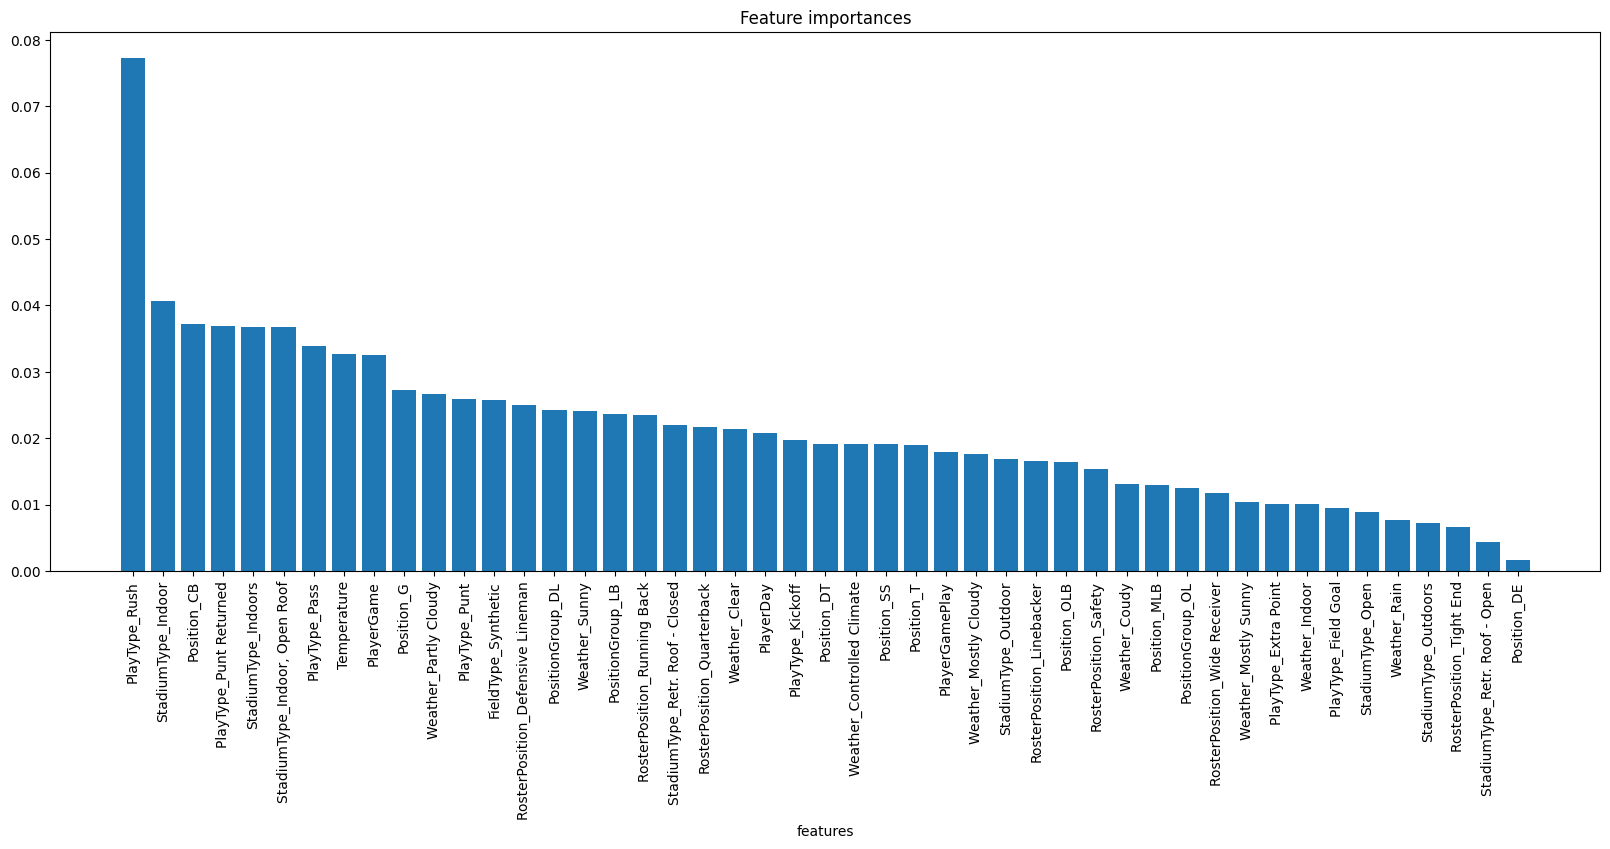

In [45]:
# removing features that have an importance = 0
feature_importances_above_0 = feature_importances.loc[feature_importances['importance']>0]
# plot as a bar chart
plt.figure(figsize=(20,7))
plt.bar(range(len(feature_importances_above_0)), feature_importances_above_0.importance.values)
plt.xticks(range(len(feature_importances_above_0)), feature_importances_above_0.feature.values, rotation=90)

plt.title('Feature importances')
plt.xlabel('features')
plt.show()

As shown in the plot above, rushing plays contribute the most in terms of likelihood of player injury. Games taking place in indoor stadiums also have a significant impact on the likelihood of injury. Environmental factors such as temperature also play a significant role in whether a player is injured.

Explore the correlations:

## 7. Synthetic vs Natural Turf Analysis


The result from our earlier hypothesis showed that there is a higher likelihood of injury when a player plays on synthetic turf. However, we will dive deeper in what factors contribute to this.

### 7.1  Injury vs. Weather Conditions

In [46]:
weather_injury_nat = game_injury_df[(game_injury_df['StadiumType'] == 'Outdoor') & (game_injury_df['FieldType'] == 'Natural')].groupby('Weather')['Injury'].mean().reset_index()
weather_injury_nat['Injury'] = weather_injury_nat['Injury'].round(3)
weather_injury_synth = game_injury_df[(game_injury_df['StadiumType'] == 'Outdoor') & (game_injury_df['FieldType'] == 'Synthetic')].groupby('Weather')['Injury'].mean().reset_index()
weather_injury_synth['Injury'] = weather_injury_synth['Injury'].round(3)


# removing snow since it shows no injuries

weather_injury_nat = weather_injury_nat.loc[weather_injury_nat['Weather'] !='Snow']
weather_injury_synth = weather_injury_synth.loc[weather_injury_synth['Weather'] !='Snow']

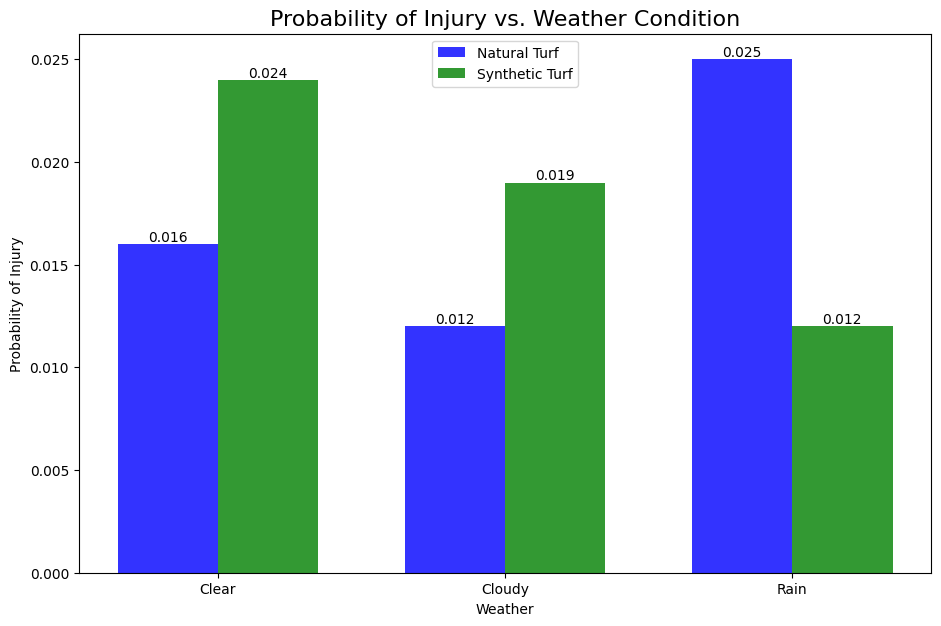

In [47]:
# visualize the stadium type for natural and synthetic turf
n_groups = len(weather_injury_synth)
fig, ax = plt.subplots(figsize=(11,7))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

nat4 = plt.bar(index, weather_injury_nat.Injury.values, bar_width,
alpha=opacity,
color='b',
label='Natural Turf')

synth4 = plt.bar(index + bar_width, weather_injury_synth.Injury.values, bar_width,
alpha=opacity,
color='g',
label='Synthetic Turf')

plt.xticks(index + bar_width/2, weather_injury_synth.Weather.values)
plt.xlabel('Weather')
plt.ylabel('Probability of Injury')
plt.legend()
ax.bar_label(nat4)
ax.bar_label(synth4)
plt.title('Probability of Injury vs. Weather Condition', fontsize=16)
#add_value_labels(ax, decimals = 3)
plt.show()

 Based on the observations above, the probability pattern of player injury peak appears in two scenarios:
- **Rain + Natural turf**
- **Clear (sunny) + Synthetic turf**

This motivates two follow-up questions:
1. **Rain on natural turf:** Is injury probability on *natural* surfaces higher in rainy outdoor games than in comparable non-rainy outdoor games?
2. **Clear weather on synthetic turf:** Is injury probability on *synthetic* surfaces higher in clear outdoor games than in comparable non-clear outdoor games—and is this effect amplified at higher temperatures?


### 7.1.1 Hypothesis Test: Risk of Injury is increased during rainy days

Another hypothesis test we can perform is to understand whether the risk of injury on natural turf is increased on rainy days.

Null hypothesis: The probability of injury on natural turf on rainy days is lower or equal than the injury probability when those conditions are not met.
Alternative hypothesis: The probability of injury on natural turf on rainy days is higher than the injury probability when those conditions are not met.

In [48]:
# get number of trials and overall injury rate under null
hyp_df = game_injury_df[['StadiumType', 'FieldType', 'Weather', 'Injury']][game_injury_df['StadiumType'] == 'Outdoor']

n_other = len(hyp_df[(hyp_df.FieldType != 'Natural') & (hyp_df.Weather != 'Rain')])

n_natural_rain = len(hyp_df[(hyp_df.FieldType == 'Natural') & (hyp_df.Weather == 'Rain')])

p_null = len(hyp_df[(hyp_df.FieldType != 'Natural') & (hyp_df.Weather != 'Rain')]) / len(hyp_df)

p_injury_1 = hyp_df[(hyp_df.FieldType == 'Natural') & (hyp_df.Weather == 'Rain')].Injury.mean()
p_injury_0 = hyp_df[(hyp_df.FieldType != 'Natural') & (hyp_df.Weather != 'Rain')].Injury.mean()

# compute standard error
se_p = np.sqrt(p_null * (1-p_null) * (1/n_other + 1/n_natural_rain))

#  compute z-score and p-value
z = (p_injury_1 - p_injury_0) / se_p

print('The z-score is: {}'.format(z))
print('The p-value is: {}'.format(1-ss.norm.cdf(z)))

The z-score is: 0.10799355288655726
The p-value is: 0.4570004031759113


Due to the fact the p-value is higher than our significance level, and we cannot reject the null hypothesis. There is no statistical significance that natural turf is leads to a higher likelihood of injury in rainy weather.

### 7.2 Injury and Synthetic turf at high temperatures/clear weather

In [49]:
# getting the distribution of temperature for plays associated with the injury on synthetic turf
temp = game_injury_df[(game_injury_df.StadiumType == 'Outdoor') & (game_injury_df.FieldType == 'Synthetic')& (game_injury_df.Injury == 1)]\
.Temperature.values

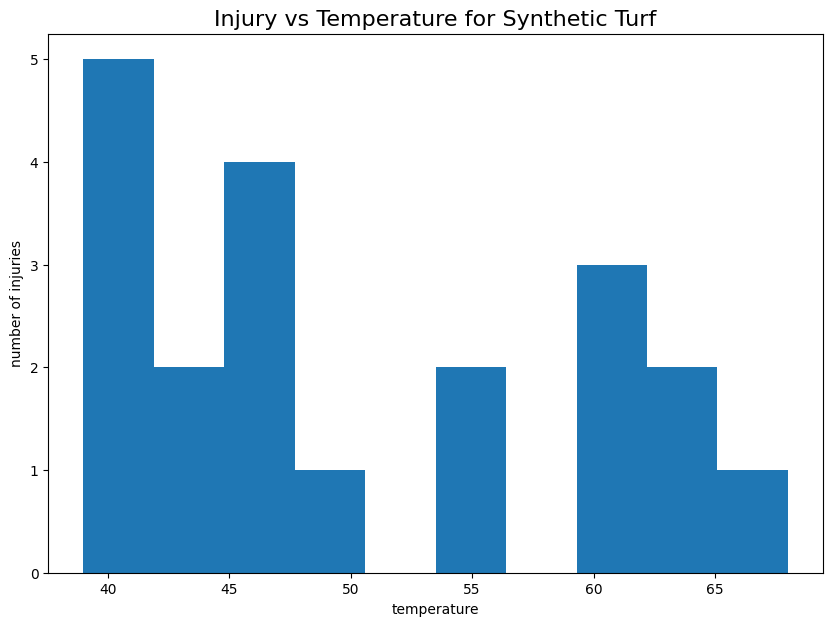

In [50]:
# plot the temperature distribution for injury on synthetic turf
plt.figure(figsize=(10,7))
plt.title('Injury vs Temperature for Synthetic Turf', fontsize=16)
plt.xlabel('temperature')
plt.ylabel('number of injuries')
plt.hist(temp)
plt.show()

To better understand the temperature effect, the histogram for synthetic turf injuries doesn’t show a clear increase at very high temperatures. Injuries appear more common in cooler conditions, suggesting heat alone may not be a primary driver in this dataset.


### 7.3 Injury on Synthetic Turf with Clear Weather vs Other Conditions

In [51]:
n_other = len(hyp_df[(hyp_df.FieldType != 'Synthetic') & (hyp_df.Weather != 'Clear')])
n_synth_clear = len(hyp_df[(hyp_df.FieldType == 'Synthetic') & (hyp_df.Weather == 'Clear')])

p_null = len(hyp_df[(hyp_df.FieldType != 'Synthetic') & (hyp_df.Weather != 'Clear')]) / len(hyp_df)

p_injury_1 = hyp_df[(hyp_df.FieldType == 'Synthetic') & (hyp_df.Weather == 'Clear')].Injury.mean()
p_injury_0 = hyp_df[(hyp_df.FieldType != 'Synthetic') & (hyp_df.Weather != 'Clear')].Injury.mean()

# compute standard error
se_p = np.sqrt(p_null * (1-p_null) * (1/n_other + 1/n_synth_clear))

#  compute z-score and p-value
z = (p_injury_1 - p_injury_0) / se_p

print('The z-score is: {}'.format(z))
print('The p-value is: {}'.format(1-ss.norm.cdf(z)))

The z-score is: 0.3269714097114601
The p-value is: 0.37184475473771617


Since our p-value is too high, we cannot reject the null hypothesis. Weather conditions interacting with field types does not indicate a higher risk of injury.

### 7.3 Probability of Injury on Synthetic Turf for Different Player Positions

In [52]:
# natural turf
pos_injury_nat = play_injury_df[(play_injury_df['FieldType'] == 'Natural')]\
.groupby(by=['Position'])['Injury'].mean().reset_index().sort_values(by=['Position'])

# synthetic turf
pos_injury_synth = play_injury_df[(play_injury_df['FieldType'] == 'Synthetic')]\
.groupby(by=['Position'])['Injury'].mean().reset_index().sort_values(by=['Position'])



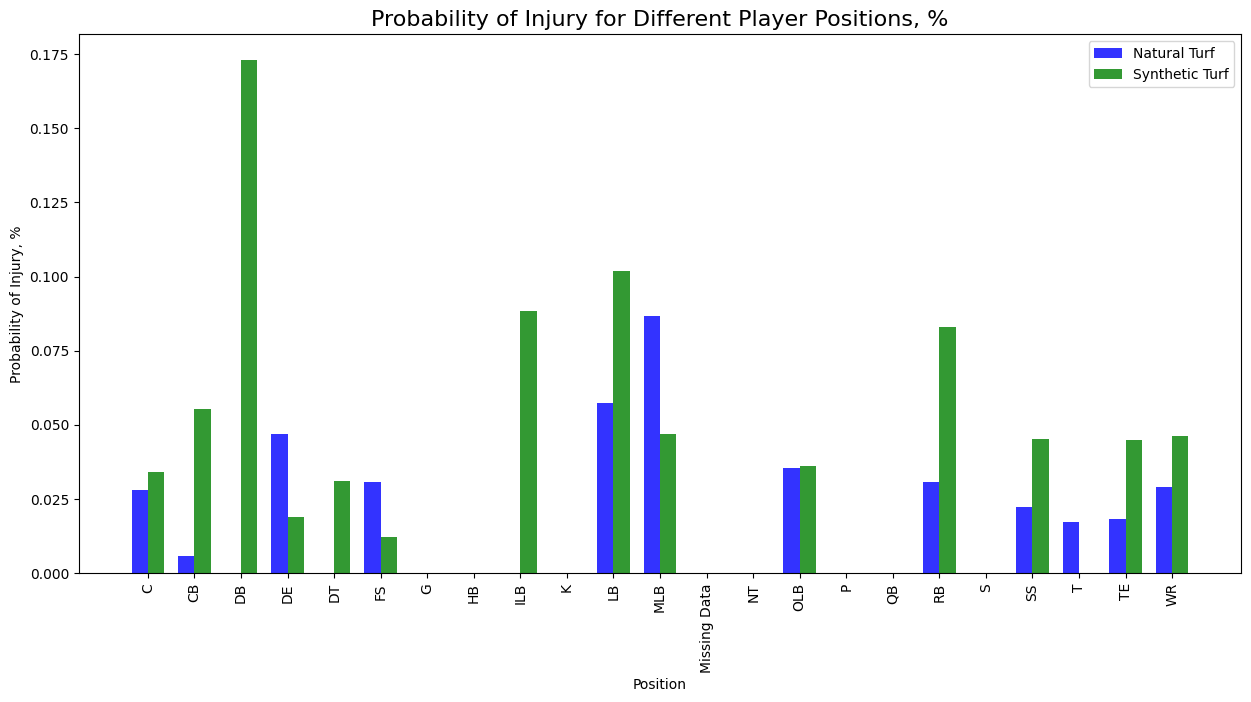

In [53]:
n_groups = len(pos_injury_nat)
fig, ax = plt.subplots(figsize=(15,7))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, pos_injury_nat.Injury.values*100, bar_width,
alpha=opacity,
color='b',
label='Natural Turf')

rects2 = plt.bar(index + bar_width, pos_injury_synth.Injury.values*100, bar_width,
alpha=opacity,
color='g',
label='Synthetic Turf')

plt.xticks(index + bar_width/2, pos_injury_synth.Position.values, rotation=90)
plt.xlabel('Position')
plt.ylabel('Probability of Injury, %')
plt.legend()
plt.title('Probability of Injury for Different Player Positions, %', fontsize=16)

plt.show()

It looks like Defensive backs have a higher chance of injury on synthetic turf

Let's do some hypothesis testing to prove that there are higher chances of injury for DB players on synthetic turf:

In [54]:
hyp_df = play_injury_df[['FieldType', 'Position', 'Injury']]

n_other = len(hyp_df[(hyp_df.FieldType != 'Synthetic') & (hyp_df.Position != 'DB')])
n_synth_db = len(hyp_df[(hyp_df.FieldType == 'Synthetic') & (hyp_df.Position == 'DB')])

p_null = len(hyp_df[(hyp_df.FieldType != 'Synthetic') & (hyp_df.Position != 'DB')]) / len(hyp_df)

p_injury_1 = hyp_df[(hyp_df.FieldType == 'Synthetic') & (hyp_df.Position == 'DB')].Injury.mean()
p_injury_0 = hyp_df[(hyp_df.FieldType != 'Synthetic') & (hyp_df.Position != 'DB')].Injury.mean()

# compute standard error
se_p = np.sqrt(p_null * (1-p_null) * (1/n_other + 1/n_synth_db))

#  compute z-score and p-value
z = (p_injury_1 - p_injury_0) / se_p

print('The z-score is: {}'.format(z))
print('The p-value is: {}'.format(1-ss.norm.cdf(z)))

The z-score is: 0.07303732805126828
The p-value is: 0.4708882066646536


Due to the fact that our p-value is higher than our significance value, we cannot reject the null hypothesis

## Conclusions:
* There is a higher risk of injury when playing on the synthetic turf in all conditions except rain
* Defensive Backs tend to be at the highest risk of injury on synthetic turf
* A temperature increase is not related to an increased risk of injury